# Naive Bayes & SVM Model

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_validate
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('/content/drive/My Drive/NLP Project/downsampled_data.csv')
df = df.dropna(subset=['Text', 'Score'])

Merge 1-2 to be negative and 4-5 to be positve.

In [ ]:
def label_sentiment(score):
    if score <= 2:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['Sentiment'] = df['Score'].apply(label_sentiment)

Clean data by lowercasing, removing non-alphabetic characters, splitting into words, removing stopwords, stemming, and joining back into a cleaned string.

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

df['Clean_Text'] = df['Text'].apply(preprocess_text)

In [ ]:
df['text_length'] = df['Clean_Text'].apply(len)
df['word_count'] = df['Clean_Text'].apply(lambda x: len(x.split()))

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, min_df=5)
X_text = vectorizer.fit_transform(df['Clean_Text'])

In [ ]:
sentiment_feature = df[['text_length', 'word_count']].values

In [ ]:
from scipy.sparse import hstack
X_combined = hstack((X_text, sentiment_feature))

y = df['Sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.1, stratify= df['Sentiment'], random_state=42)

# Naíve Bayes Model


In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train[:, :X_text.shape[1]], y_train)
nb_preds = nb_model.predict(X_test[:, :X_text.shape[1]])


=== Naive Bayes Performance ===
Accuracy: 0.6710
              precision    recall  f1-score   support

           0       0.68      0.84      0.75       400
           1       0.67      0.02      0.04       200
           2       0.66      0.82      0.74       400

    accuracy                           0.67      1000
   macro avg       0.67      0.56      0.51      1000
weighted avg       0.67      0.67      0.60      1000



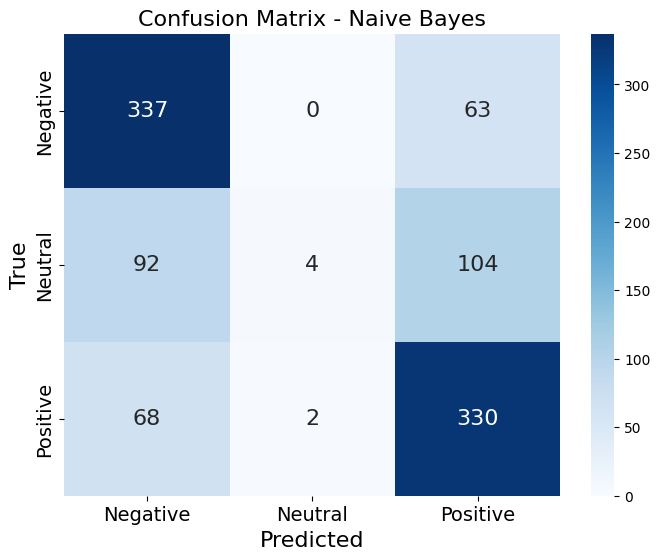

In [ ]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n=== {name} Performance ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'],
                annot_kws={"size": 16})  # Set font size of annotations
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('True', fontsize=16)
    plt.title(f'Confusion Matrix - {name}', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

evaluate_model("Naive Bayes", y_test, nb_preds)

# SVM

In [ ]:
param_grid_svm = {'C': [0.1, 1, 10]}
grid_svm = GridSearchCV(LinearSVC(max_iter=100000), param_grid_svm, cv=3, verbose=1)
grid_svm.fit(X_train, y_train)
svm_model = grid_svm.best_estimator_
svm_preds = svm_model.predict(X_test)
print(f"Best SVM parameters: {grid_svm.best_params_}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Best SVM parameters: {'C': 0.1}


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



=== SVM Performance ===
Accuracy: 0.6820
              precision    recall  f1-score   support

           0       0.67      0.86      0.75       400
           1       0.66      0.12      0.20       200
           2       0.70      0.79      0.74       400

    accuracy                           0.68      1000
   macro avg       0.68      0.59      0.56      1000
weighted avg       0.68      0.68      0.64      1000



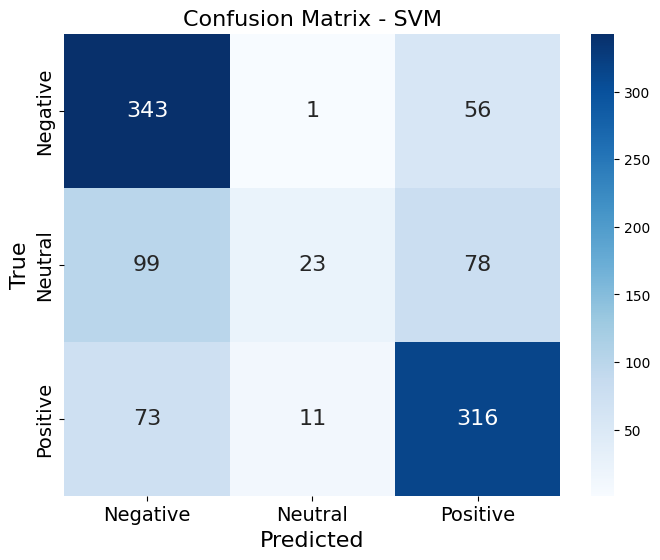

In [ ]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n=== {name} Performance ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'],
                annot_kws={"size": 16})  # Set font size of annotations
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('True', fontsize=16)
    plt.title(f'Confusion Matrix - {name}', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

evaluate_model("SVM", y_test, svm_preds)